In [1]:
%reload_ext autoreload
%autoreload 2

In this example, we explore the capabilities of FEINN in solving an homogeneous elastic perforated plate. It is subjected to uniform normal traction imder a plane-stress condition. By symmetry, only one quarter of the plate is modelled.

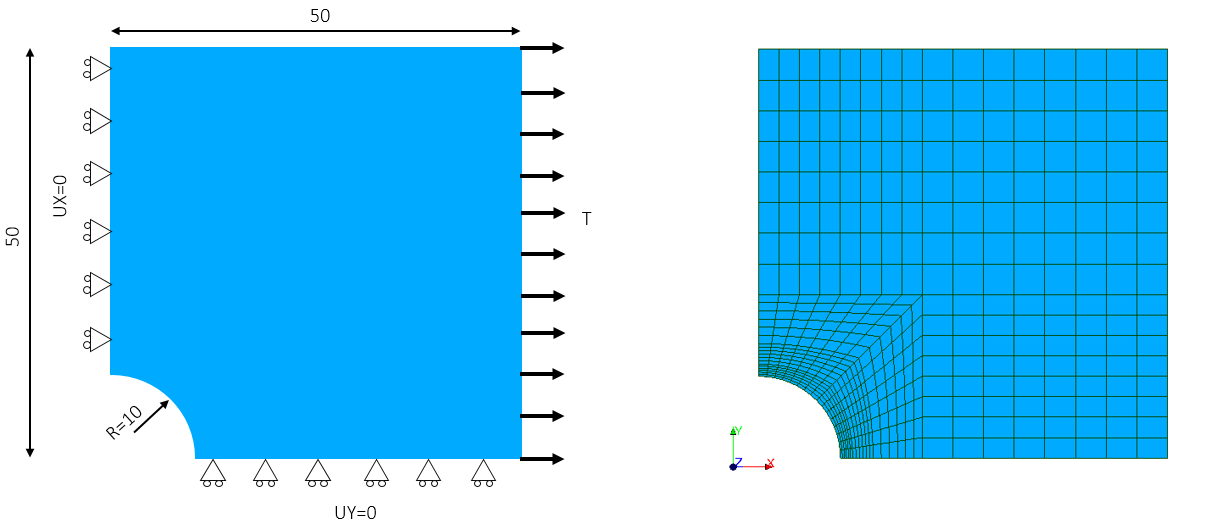

### General Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Mesh definition

In this case, we load a mesh created using SMESH module from Salome Meca platform.

In [3]:
from mesh_utils import Mesh2D

mesh = Mesh2D.from_salome_med(filepath = './PerforatedPlate.med')

Loaded SALOME .med mesh: 531 nodes, 480 elements
Node groups (4): ['left', 'right', 'top', 'bottom']
Element groups (2): ['all', 'right_s']


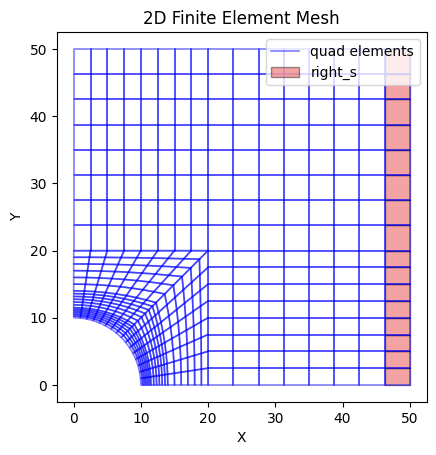

In [4]:
mesh.plot(show_nodes=False, element_groups_to_plot=['right_s'])

### Dirichlet boundary conditions

In [5]:
from feinn_solver import BoundaryCondition

bcs = {
        'left': BoundaryCondition(dof=1, value=0.0),
        'bottom': BoundaryCondition(dof=2, value=0.0),                
        }

### Define material

In [6]:
from matmodels import LinearElasticPlaneStress

steel = LinearElasticPlaneStress(emod = 200*1e3, nu = 0.30)

matfield = {'all': steel}

### von Neumman boundary conditions

In [7]:
from feinn_solver import EdgeLoad

traction = {
            'right_s': EdgeLoad(side = 1, ftangential = 0.0, fnormal = 100, reference = "global"),
            }


### Model

In [8]:
from feinn_solver import NFEA

fem_solver = NFEA(mesh = mesh, 
                      bcs = bcs, 
                      matfld = matfield,
                      edge_loads = traction,
                      verbose = True
                      )

[matfld] Assigned: ['all']
[matfld] All 480 elements have assigned material
[edge_load] Applied 1 edge load groups
[BC] Processed 2 Dirichlet condition(s) → 54 total constraint(s)
[BC] Applied Dirichlet BCs → 54 fixed DOFs


In [9]:
# assign thickness to elements
for elem_i in fem_solver.elements:
    elem_i.thickness = 0.10

In [10]:
fem_solver.Fext_total

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [11]:
fem_solver.formulation = 'infinitesimal'
fem_solver.run_complete(nsteps=1)

[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 2.47e-14  Energetic error: 1.00e+00
Iter   2 | du error: 5.53e-15  Res error: 9.09e-15  Energetic error: -1.23e-16
Converged in 2 iterations


In [12]:
fem_solver.udisp

tensor([ 0.1242,  0.0000,  0.1331,  ..., -0.0613,  0.0110, -0.0625])

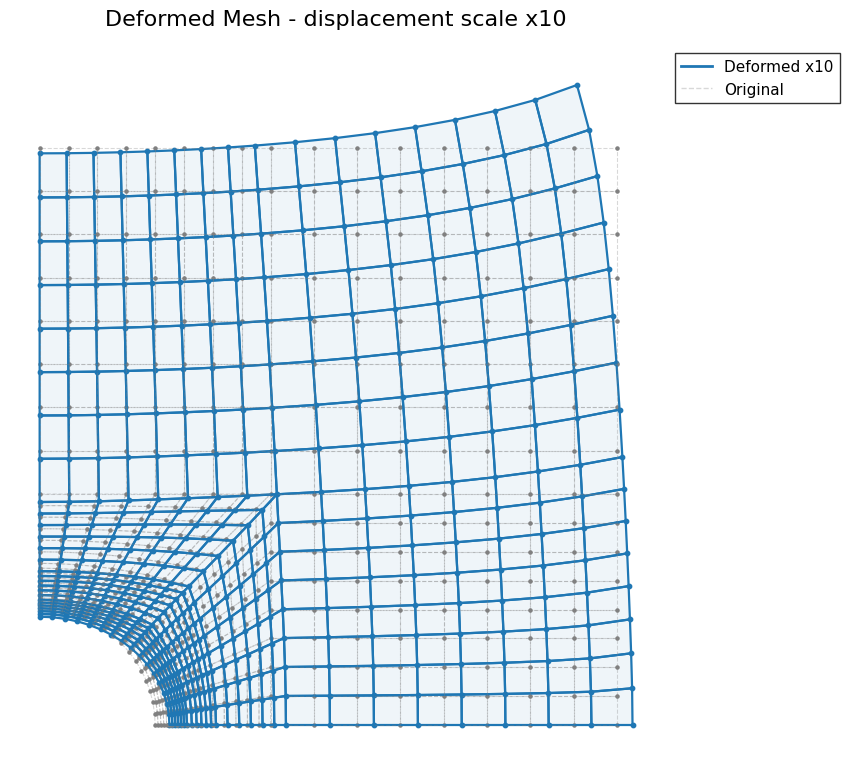

In [15]:
fem_solver.plot_deformed_mesh(scale=10)

In [14]:
Fint_fem = fem_solver._assemble_internal_forces(fem_solver.udisp)
Fint_fem

tensor([-3.5072e-13,  1.5350e+01,  2.8422e-14,  ...,  5.5911e-13,
        -5.6843e-14,  1.0929e-12])

In [ ]:
from feinn_solver import FEINN
from nn_models import mFCNet, FCResNet
import torch.nn as nn

feinn_solver = FEINN(
    mesh=cantilever_mesh,
    bcs=cantilever_bc,
    matfld=cantilever_matfld,
    edge_loads=cantilever_edge_loads,
    verbose=False,
    nnet = mFCNet(),
    bc_weight=1e6,
    nnet_init = 'xavier',
    )

feinn_solver.formulation = formulation

# assign thickness to elements
for elem_i in feinn_solver.elements:
    elem_i.thickness = 0.1